# Model Selection and Evaluation - Part 2

## Exercise 3 - Cross Validation

In the previous activity, we made the classic mistake of using our validation data to predict our generalization error. This tends to give misleadingly optimistic predictions about how well we will do on unobserved data. Remember that we carefully picked our hyperparameter values to do as well as possible *on our held-out data*. We shouldn't be surprised when our model performs better on that data than on unobserved data. This problem is particularly acute if our data set is small.

The traditional solution is to divide our data into three disjoint sets: **training**, **validation**, and **testing**:
* The **training** set is used to fit the model.
* The **validation** set is used to evaluate models for the purpose of hyperparameter selection. 
* The **test** set is kept in a locked room guarded by jaguars. We only look at the testing set ONCE, when we have finalized our model. That way our performance on the test set gives us an unbiased estimate of our generalization error.

This traditional approach is fine if we have a lot of data to work with. If the data set is small, we are faced with a painful dilemma: More validation data means better model selection. More testing data means more accurate model evaluation. More training data means better models. Any data we use for one purpose can't be used for the others.

**Cross validation** is one way to use limited data more effectively.  The cells below walk us through an example of using cross validation for hyperparameter tuning.

In [1]:
# We need to reimport and reload everything...
#%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import sprinkle_data

from sklearn.tree import DecisionTreeRegressor

# Grab our training data
source = sprinkle_data.SprinkleDataSource()
X, y = source.gen_data(100, seed=100)

# Split our data into a training and testing set...
split_point = int(X.shape[0] * .8) # Use 80% of the data to train the model

X_train = X[:split_point, :]
y_train = y[:split_point]

X_test = X[split_point:, :] # This data will ONLY be used for final evaluation.
y_test = y[split_point:]

The following cell shows how we can use the scikit-learn `KFold` class to automatically split up our training data for k-fold cross validation. Take a minute to read through this code to make sure you understand what's going on.

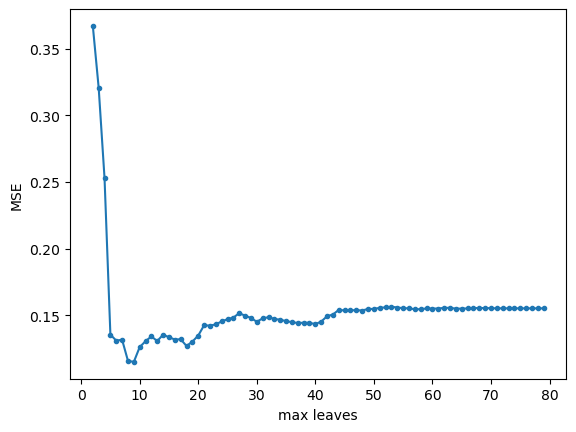

In [2]:
from sklearn.model_selection import KFold

folds = 10
max_max_leaves = 80
kf = KFold(n_splits=folds)

mses = np.zeros((folds, max_max_leaves - 2)) # (can't have 0 or 1 leaves)

# Loop over all of the hyperparameter settings
for max_leaves in range(2, max_max_leaves):
    
    k = 0
    
    # Evaluate each one K-times
    for train_index, val_index in kf.split(X_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        tree = DecisionTreeRegressor(max_leaf_nodes=max_leaves)
        tree.fit(X_tr, y_tr)
        
        y_val_predict = tree.predict(X_val)
        mses[k, max_leaves - 2] = np.sum((y_val - y_val_predict)**2) / y_val.size
        
        k += 1
        
# Average across the k folds
mse_avg = np.mean(mses, axis=0)

plt.plot(np.arange(2, max_max_leaves), mse_avg, '.-')
plt.xlabel('max leaves')
plt.ylabel('MSE')
plt.show()

If we are real experts in scikit-learn, we can automate some of this by using the `cross_val_score` function:  

(There are also library routines for [automating the entire process of hyperparameter tuning](https://scikit-learn.org/stable/modules/grid_search.html).) 

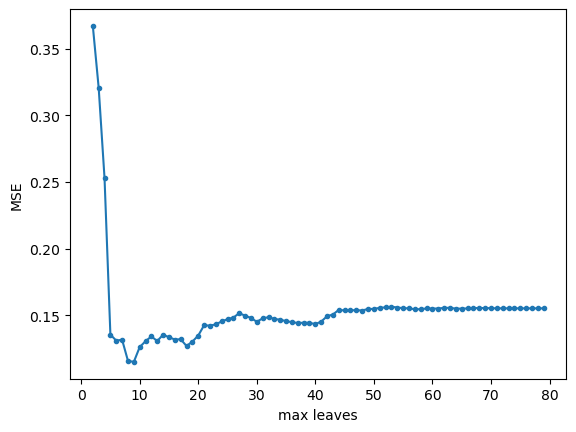

In [3]:
# THIS CODE CELL ACCOMPLISHES THE SAME THING AS THE PREVIOUS ONE.

from sklearn.model_selection import cross_val_score

mses = np.zeros((folds,max_max_leaves - 2))

# Loop over all of the hyperparameter settings
for leaves in range(2, max_max_leaves):
    tree = DecisionTreeRegressor(max_leaf_nodes=leaves)
    
    # Returns an array of cross validation results.
    mses[:, leaves - 2] = -cross_val_score(tree, X_train, y_train, 
                                         cv=folds, scoring='neg_mean_squared_error')
    
mse_avg = np.mean(mses, axis=0)

plt.xlabel('max leaves')
plt.ylabel('MSE')
plt.plot(np.arange(2, 80), mse_avg, '.-')
plt.show()



### Question

* Based on the results above, what is the most promising hyperparameter value?

Around 7-8 max_leaf_nodes

Now that we have a value for our hyperparameter, let's train our final model on the *full* training set and use our locked-away testing set to predict model performance.

In [8]:
tree = DecisionTreeRegressor(max_leaf_nodes=7) # Put your best hyperparameter here!

# Train using ALL the training data
tree.fit(X_train, y_train)

# Test on held-out testing data
y_test_predict = tree.predict(X_test)
mse = np.sum((y_test - y_test_predict)**2) / y_test.size

print("Predicted MSE: {:.4f}".format(mse))

Predicted MSE: 0.0662


Since none of the data we are testing on here was used *in any way* to design or fit the model, this value should give us an unbiased estimate of our generalization error.  Let's try testing on some new unobserved data to see how good our estimate is:

In [9]:

# Let's see how we do on unobserved data... 
X_new, y_new = source.gen_data(100000, seed=200)
y_new_predict = tree.predict(X_new)
mse = np.sum((y_new - y_new_predict)**2) / y_new.size
print("MSE: {:.4f}".format(mse))

MSE: 0.1223


### Questions

Take a look back at the results from Exercise 2 and answer the following questions:

* Did the cross validation approach improve our results in terms of *model selection* (i.e. did we end up with a better model)?  Justify your answer.
* Did maintaining a proper test set improve our results in terms of *model evaluation* (i.e. did we make a more accurate prediction about our generalization error)?  Justify your answer.

Cross validation effectively made predictions with a smaller data set and it slightly improved our results for our evaluation. This model works better than what we worked with previously.
The predicted MSE from exercise 2 was 0.0966, while here, the predicted MSE is 0.0662 in terms of model selection. Therefore, cross validation seemed to have slightly improved our results and gave us a better model.

## Exercise 4 - Bias Variance Decomposition

we spent some time earlier considering the bias/variance decomposition: 

$$E[(y - \hat{f}(x))^2] = (Bias[\hat{f}(x)])^2 + Variance[\hat{f}(x)] + \sigma^2$$

### Questions

* What part of the formula above corresponds to the notion of *generalization error* that we have been discussing?
* How is hyperparameter selection related to the Bias term?
* How is the training set size related to the Variance term?


E[(y-f(x))^2]

The hyperparameter selection directly impacts the bias. It's usually perpendicular to bias so if we had lower max_leaf_nodes, we'd get a higher bias. 

The opposite remains true too.
Training set size affects the variance term where bigger data sets have lower variance and the opposite is true.

## Exercise 5 - Nested Cross Validation

There is still one drawback of our approach from the previous exercise:  Our testing set was quite small, which limits the reliability of our model evaluation. Maybe the test set happens to contain particularly difficult or particularly easy instances? 

In a perfect world, we would like to be able to use *all* of our data for training and validation and *all* of our data for testing.  In a way, we can accomplish this by using **nested cross validation**.  This involves generating K-fold data splits at two levels. At the top level, we iterate over Testing/Training splits for the purpose of model evaluation.  For *each* Training/Testing split we iterate over Training/Validation splits for the purpose of model tuning.  This page provides an [example of nested cross-validation using scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html). 

If you have time, go ahead and use nested cross validation to redo our example above.  Does it improve our estimate of generalization error? 